## <center>Project 4: AdaBoost Regression and Random Forests</center>

**Name: Doungporn Wiwatanapataphee**<br>
**Date created:** 19 April 2021<br>

### Contents

1. [Project 1: Predicting Abalone's ring using AdaBoost Regressor](#1) <br>
    1.1 [Data loading, visualisation, and cleaning](#1.1) <br>
    1.2 [Set up, training, and prediction](#1.2) <br>
    1.3 [Results and plots](#1.3) <br>
    1.4 [Comparison and summary](#1.4) <br>
2. [Project 2: Predicting red wine quality using Random Forests](#2) <br>
    2.1 [Data loading and visualisation](#2.1) <br>
    2.2 [RF Regressor on full dimensional data](#2.2) <br>
    2.3 [Feature importance & dimensionality reduction](#2.3) <br>
    2.4 [RF Regressor on reduced-dimensional data](#2.4) <br>
    2.5 [Comparison and conclusion](#2.5) <br>
3. [References](#Ref)

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import os
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings("ignore")

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### 1. Project 1: Predicting Abalone's rings using AdaBoost Regressor <a class="anchor" id="1"></a>

Abalones are marine snails, which their age can be determined by counting the number of rings through the microscope. However, the tasks required to inspect abalone's rings are considered tedious and time-consuming. Thus, the number of rings is instead determined using different set of measurements, which are much easier to obtain. 

In project 1, prediction of the number of abalone's rings using ensemble methods AdaBoost is conducted.

#### 1.1 Data loading, visualisation, and cleaning <a class="anchor" id="1.1"></a>

Firstly, the data was loaded using the `read_csv()` function with the columns' name taken from the <a href="http://archive.ics.uci.edu/ml/datasets/Abalone">UCI's Abalone dataset</a> information. The functions `head()` and `info()` were employed to initially inspect the structure of the data. Then, a pair plot of all the numerical features were illustrated together with the corresponding correlation matrix. From here, we can notice the followings:

- Abalone dataset consists of **4177 observations** of **9 variables**. There are seven numerical variables, which are weight-based (Shell, Viscera, and Shucked), dimension-based (Length, Diameter, and Height), and the number of rings (Rings). There is one categorical variable, Sex, which will be converted to numerical columns using a function `OneHotEncoder()`, as most Machine Learning algorithms prefer to work with numbers.
- There are no missing data, and the values of numerical variables except the target Rings are between 0 and 1. This suggests that the data might already be scaled.
- By observing the pair plot, we can inspect the distribution of each features as well as the relationship between each variable pair. It is noticeable that all the features are either right- or left-skewed. Also, a strongly positive exponential relationship between variables weights (Shell, Viscera, and Shucked) and dimensions (Length, Diameter, and Height) is observed. 
- In addition, the weight based features show strong linear relationship with each others, which might raises concern about multicolinearity if we conduct linear regression analysis. Nonetheless, multicolinearity does not affect the accuracy and prediction of the AdaBoost regressor, so we can probably overlook the issue.
- Of all the features, **Shell weight** are the most correlated to the target **Rings** with the correlation of 0.6276.
- The pairwise correlations between features and the target **Rings** suggest that **Shucked weight** and **Viscera weight** should be removed for the subsequent training and testing steps, since their relation to the target are not as strong as other features'.

Once we have done some data exploration, data cleaning processes were performed such that the categorical Sex are converted and the two features with the least relation to the target are dropped. After data cleaning, we ended up with a dataframe of **4177 observations** of **8 variables** including the target Rings.

The code snippets to performed the tasks and their outputs are shown as follows: 

In [2]:
# Data loading
cols = ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight',
        'Viscera weight', 'Shell weight', 'Rings']
abalone = pd.read_csv('abalone.data', names=cols)
abalone.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [3]:
# Checking the data structure
abalone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


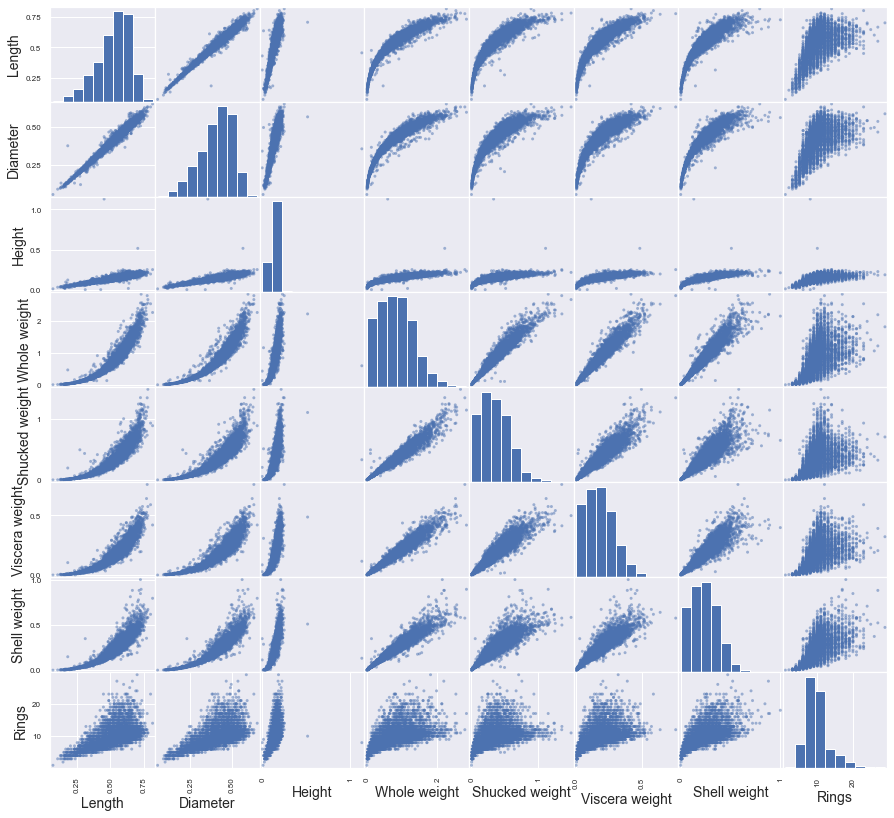

In [4]:
# Visualisation
from pandas.plotting import scatter_matrix
scatter_matrix(abalone, figsize=(15, 14));

In [5]:
# Pairwise correlation of features
abalone.corr()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
Length,1.000000,0.986812,0.827554,0.925261,0.897914,0.903018,0.897706,0.556720
Diameter,0.986812,1.000000,0.833684,0.925452,0.893162,0.899724,0.905330,0.574660
Height,0.827554,0.833684,1.000000,0.819221,0.774972,0.798319,0.817338,0.557467
Whole weight,0.925261,0.925452,0.819221,1.000000,0.969405,0.966375,0.955355,0.540390
Shucked weight,0.897914,0.893162,0.774972,0.969405,1.000000,0.931961,0.882617,0.420884
Viscera weight,0.903018,0.899724,0.798319,0.966375,0.931961,1.000000,0.907656,0.503819
Shell weight,0.897706,0.905330,0.817338,0.955355,0.882617,0.907656,1.000000,0.627574
Rings,0.556720,0.574660,0.557467,0.540390,0.420884,0.503819,0.627574,1.000000


In [6]:
# Relabel 'M' and 'F' to 'A'
abalone['Sex'] = abalone['Sex'].replace(['M','F'],'A')
abalone['Sex'].value_counts()

A    2835
I    1342
Name: Sex, dtype: int64

In [7]:
# Convert Sex column into two numerical columns: Sex_A and Sex_I
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
Sex_1h = pd.DataFrame(cat_encoder.fit_transform(abalone[['Sex']]).toarray())
Sex_1h.columns = cat_encoder.get_feature_names(['Sex'])

# Drop Sex, and merge new one-hot encoder columns with the data frame
abalone.drop(['Sex'] ,axis=1, inplace=True)
abalone = pd.concat([abalone, Sex_1h], axis=1)
abalone.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Sex_A,Sex_I
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,1.0,0.0
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,1.0,0.0
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,1.0,0.0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,1.0,0.0
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,0.0,1.0


In [8]:
# Remove Shucked weight and Viscera weight
del abalone['Shucked weight']
del abalone['Viscera weight']
abalone.describe().T

,count,mean,std,min,25%,50%,75%,max
Length,4177.0,0.523992,0.120093,0.0750,0.4500,0.5450,0.615,0.8150
Diameter,4177.0,0.407881,0.099240,0.0550,0.3500,0.4250,0.480,0.6500
Height,4177.0,0.139516,0.041827,0.0000,0.1150,0.1400,0.165,1.1300
Whole weight,4177.0,0.828742,0.490389,0.0020,0.4415,0.7995,1.153,2.8255
Shell weight,4177.0,0.238831,0.139203,0.0015,0.1300,0.2340,0.329,1.0050
Rings,4177.0,9.933684,3.224169,1.0000,8.0000,9.0000,11.000,29.0000
Sex_A,4177.0,0.678717,0.467025,0.0000,0.0000,1.0000,1.000,1.0000
Sex_I,4177.0,0.321283,0.467025,0.0000,0.0000,0.0000,1.000,1.0000


In [9]:
abalone.info() # Inspect after data cleaning

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Length        4177 non-null   float64
 1   Diameter      4177 non-null   float64
 2   Height        4177 non-null   float64
 3   Whole weight  4177 non-null   float64
 4   Shell weight  4177 non-null   float64
 5   Rings         4177 non-null   int64  
 6   Sex_A         4177 non-null   float64
 7   Sex_I         4177 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 261.2 KB


#### 1.2 Set up, training, and prediction <a class="anchor" id="1.2"></a>

The section started with extracting the target Rings from other features and named them `y` and `X`, respectively. Then, they were randomly splited into training (85%) and test (15%) set using the `train_test_split()` function.

For the AdaBoost Regressor, the Support Vector regressor (SVR) with an RBF kernel was employed as the base estimator. Grid searching on SVR's hyperparameters was performed to optimise the performance of the estimator. However, the grid search code is omitted to shorten runtime of the Jupyter Notebook. The grid searching was performed using mean absolute error scoring (`scoring='neg_mean_absolute_error'`) as the evaluation metric. The parameter grid consisting of three hyperparameters:

- `C` is a regularisation parameter, which determines the strength of regularisation using the squared l2 penalty. The default value is 1, so we try grid searching on both lower and higher values. Thus, the parameter grid for C is a list of 0.1, 1, 10, and 100.
- `epsilon` specifies the epsilon-tube within which no penalty is associated in the training loss function with points predicted within a distance epsilon from the actual value. Its default value is 0.1, so we try grid searching from a list of 0.01, 0.1, 1, and 10.
- `gamma` is the kernel coefficient for RBF kernel, which defines how much influence a single training instance has. The default gamma parameter is set to `scale`, which computed from the formula 1 / (n_features * X.var()) = 0.9193 $\approx$ 1. So, we definitely try 1 and a few values above and below 1. Hence, the parameter grid for gamma is a list of 0.1, 1, 3, and 5.

The `best_params_` from `GridSearchCV` object suggests the best set of hyperparameters are C=10, epsilon=0.01, and gamma=5. Therefore, the SVR base estimator is built using these hyperparameters.

Grid searching was also performed on three hyperparameters of AdaBoost Regressor using mean absolute error as model evaluation metric (`scoring='neg_mean_absolute_error'`):

- `n_estimators` specifies the maximum number of estimators at which boosting is terminated, allowing for early stopping. The default value is 50. However, the instruction suggests trying 4 or 5 estimators.
- `learning_rate` is the value by which the contribution of each regressor is shrinked. Lower or higher learning rate might results in overfitting or underfitting model, so we do not want to include too many extreme options. The default learning rate is 1, and we try grid searching on this value together with 0.5 and 2. 
- `loss` specifies the loss function to use when updating the weights after boosting iteration. There are three loss function options- namely, linear, square, and exponential, whereas linear is set as default. Grid searching is performed for all three available loss functions.

`GridSearchCV` object of AdaBoost Regressor suggests the best set of hyperparameters where n_estimators=4, learning_rate=0.5, and loss='linear'. Once these hyperparameters' value were obtained, AdaBost Regressor was then set up, trained, and tested.

In addition, four additional functions were defined to help generating and visualising the prediction results:

- `pred_eval(reg, X_train, X_test, y_train, y_test)` function is employed to generate prediction results of the final model based on training and test sets. Since the target values (Rings) must be integers, the prediction of the model obtained from `predict()` is passed as an argument to `round()` function. Then, the mean absolute errors (MAEs) of the intermediate and final models on training and test sets can be determined using the `staged_predict()` and `mean_absolute_error()` functions. The function requires five parameters: regressor, training set features (X_train), test set features (X_test), training set target (y_train), and test set target (y_test). Four arrays, which consists of prediction on test set (test_pred), predictions on training set (train_pred), test set MAEs (test_MAEs), and training set MAEs (training_MAEs) are returned when the function is called.  
- `plot_MAEs(reg, test_MAEs, train_MAEs, min, max)` function is used to plot the MAEs for the training and test sets on the same plot. It requires five parameters: regressor, MAEs for the test and training sets, and the minimum and maximum values for y-axis, respectively.
- `plot_predictions(data, pred)` function plots the orginal data (data) and prediction results (pred) in blue dots and red line, repectively.
- `plot_errors(data, pred)` function plots the histogram showing distribution of raw prediction errors. The function requires the original target (data) and the prediction results (pred).

The code snippets to perform the tasks are shown as follows: 

In [10]:
# Extract target from features
X = abalone.drop(['Rings'], axis=1)
y = abalone.Rings

In [11]:
# Training and Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [ ]:
# Grid Search on SVR
#from sklearn.svm import SVR
#from sklearn.model_selection import GridSearchCV

#param_grid = {'C': [0.1, 1, 10, 100],
#              'epsilon': [0.01, 0.1, 1, 10],
#              'gamma': [0.1, 1, 3, 5]
#             }
#svm_reg = SVR(kernel='rbf')
#grid_search = GridSearchCV(svm_reg, param_grid, cv=3, 
#                           scoring='neg_mean_absolute_error')
#grid_search.fit(X_train, y_train)
#grid_search.best_params_

In [12]:
# Base estimator SVR with RBF kernel
from sklearn.svm import SVR
svm_reg = SVR(kernel='rbf', gamma=5, C=10, epsilon=0.01)

In [ ]:
# Grid Search on AdaBoost Reg
#from sklearn.ensemble import AdaBoostRegressor
#from sklearn.model_selection import GridSearchCV
#
#param_grid = {'n_estimators': [4, 5],
#              'learning_rate': [0.5, 1, 2],
#              'loss': ['linear', 'square', 'exponential']
#             }

#ada_reg = AdaBoostRegressor(svm_reg, random_state=42)
#grid_search = GridSearchCV(ada_reg, param_grid, cv=3, 
#                           scoring='neg_mean_absolute_error')
#grid_search.fit(X_train, y_train)
#grid_search.best_params_

In [13]:
# Set up and train AdaBoost Regressor
from sklearn.ensemble import AdaBoostRegressor

ada_reg = AdaBoostRegressor(svm_reg, n_estimators=4, learning_rate=0.5,
                             loss='linear',random_state=42)
ada_reg.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=SVR(C=10, epsilon=0.01, gamma=5),
                  learning_rate=0.5, n_estimators=4, random_state=42)

In [14]:
# Function for generating prediction results and MAEs
from sklearn.metrics import mean_absolute_error
def pred_eval(reg, X_train, X_test, y_train, y_test):
    
    # Final model prediction results
    test_pred = np.round(reg.predict(X_test))
    train_pred = np.round(reg.predict(X_train))
    
    # test set MAEs
    test_MAEs = np.zeros((reg.n_estimators,), dtype=np.float64)
    for i, y_pred in enumerate(reg.staged_predict(X_test)):
        test_MAEs[i] = mean_absolute_error(y_test, np.round(y_pred))

    # train set MAEs
    train_MAEs = np.zeros((reg.n_estimators,), dtype=np.float64)
    for i, y_pred in enumerate(reg.staged_predict(X_train)):
        train_MAEs[i] = mean_absolute_error(y_train, np.round(y_pred))
        
    return test_pred, train_pred, test_MAEs, train_MAEs

In [15]:
# Function to plot MAEs
def plot_MAEs(reg, test_MAEs, train_MAEs, min, max):
    fig = plt.figure(figsize=(10, 6))
    plt.ylim(min, max)
    plt.title('Mean Absolute Errors', fontsize=18)
    # plot training set MAEs in blue
    plt.plot(np.arange(reg.n_estimators) + 1, train_MAEs, 'b-',
         label='Training Set MAEs')
    # plot test set MAEs in red
    plt.plot(np.arange(reg.n_estimators) + 1, test_MAEs, 'r-',
         label='Test Set MAEs')
    # control label and legend
    plt.legend(loc='best')
    plt.xticks(np.arange(1, reg.n_estimators + 1, 1))
    plt.xlabel('Number of Estimators', fontsize=16)
    plt.ylabel('MAE', fontsize=16)
    fig.tight_layout()
    plt.show()

In [16]:
# Function to plot the prediction results
def plot_predictions(data, pred):
    x1 = range(len(data))
    plt.scatter(x1, data, s=5, color="blue", alpha=0.7, label="Original")
    plt.plot(x1, pred, lw=0.8, color="red", label="Predicted")
    plt.xlabel("Data", fontsize=16)
    plt.ylabel("Target",fontsize=16)
    plt.legend(loc='upper right', fontsize=16)

In [17]:
# Function to plot histogram showing distribution of raw prediction errors
def plot_errors(data, pred):
    errors = pred - data # positive if overestimate 
    plt.hist(errors, bins=np.arange(min(errors),max(errors)+1,1), align='mid')
    plt.xticks(np.arange(min(errors),max(errors)+1,1))
    plt.xlabel('Raw prediction errors', fontsize=16)
    plt.ylabel('Frequency', fontsize=16)

#### 1.3 Results and plots <a class="anchor" id="1.3"></a>

In this section, we made use of the functions defined in the previous part to obtain the outputs and visualise the results. Explanation will be given below each of plot.

In [18]:
# Obtain prediction results and MAEs for training and test sets
test_pred, train_pred, test_MAEs, train_MAEs = pred_eval(ada_reg, X_train, X_test, y_train, y_test)

In [19]:
train_MAEs # AdaBoost Regressor training set MAEs

array([1.48676056, 1.48676056, 1.4771831 , 1.4771831 ])

In [20]:
test_MAEs # AdaBoost Regressor test set MAEs

array([1.55661882, 1.55661882, 1.55980861, 1.55980861])

In [21]:
# SVR: test set MAE 
svm_reg.fit(X_train, y_train)
svm_pred = np.round(svm_reg.predict(X_test))
mean_absolute_error(y_test,svm_pred)

1.5390749601275917

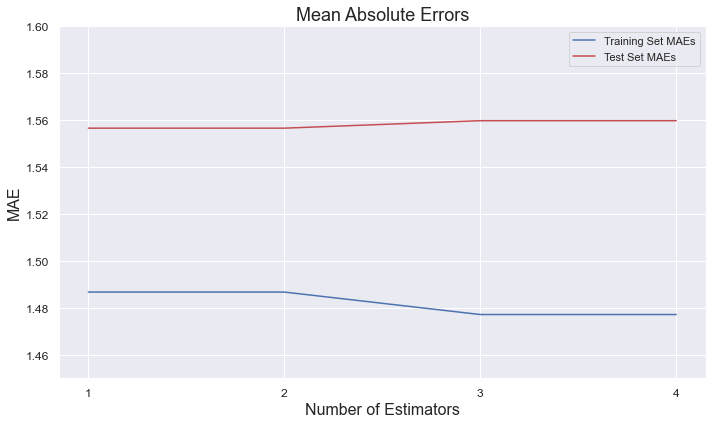

In [22]:
# MAEs plot
plot_MAEs(ada_reg, test_MAEs, train_MAEs, 1.45, 1.6)

<table style="width:100%;">
    <caption>Mean absolute errors of the intermediate and the final models</caption>
<thead><tr><th># Estimators</th><th>1</th><th>2</th><th>3</th><th>4</th></tr></thead><tbody>
 <tr><td>Training</td><td>1.4868</td><td>1.4868</td><td>1.4772</td><td>1.4772</td></tr>
 <tr><td>Test</td><td>1.5566</td><td>1.5566</td><td>1.5598</td><td>1.5598</td></tr>
</tbody></table>

The above plot and table illustrates the mean absolute errors (MAEs) of the intermediate and final models for both training (blue) and test (red) sets. Although it is obvious that training set MAEs are relatively lower than test set MAEs, the prediction on both training set and test set are off by around $\pm$2.

Since we conducted grid search on the training set using the MAE as the evaluation metrics, the best model in this case is the model that mimimise MAE of the cross-validated model on the training set. Hence, the plot shows the training set MAEs decreases as the number of estimators increases and reaches the minimum MAE at the final model of 4 estimators. The MAEs of the test set, on the other hand, slightly increases by $\approx$0.003 while the training set MAE decreases by $\approx$0.01, suggesting the model might be somewhat overfitted. This situation is expected since the SVR estimator is a fairly good estimator by itself. Therefore, it is not completely unsual that AdaBoost ensemble learning on many SVR base estimators will return an overfitting model.

Usually, we can try reducing the number of estimators or increasing the regularisation parameter `C` of the base estimator SVR to lessen the degree of overfitting in AdaBoost ensemble. In this situation, the MAEs of test set suggests that one or two estimators might be enough for the model. Nonetheless, a slight increase in test set MAEs from two to three estimators might not be an issue. Alternatively, we can also inspect the plots of the predictions on training and test set to see whether overfitting is the case.

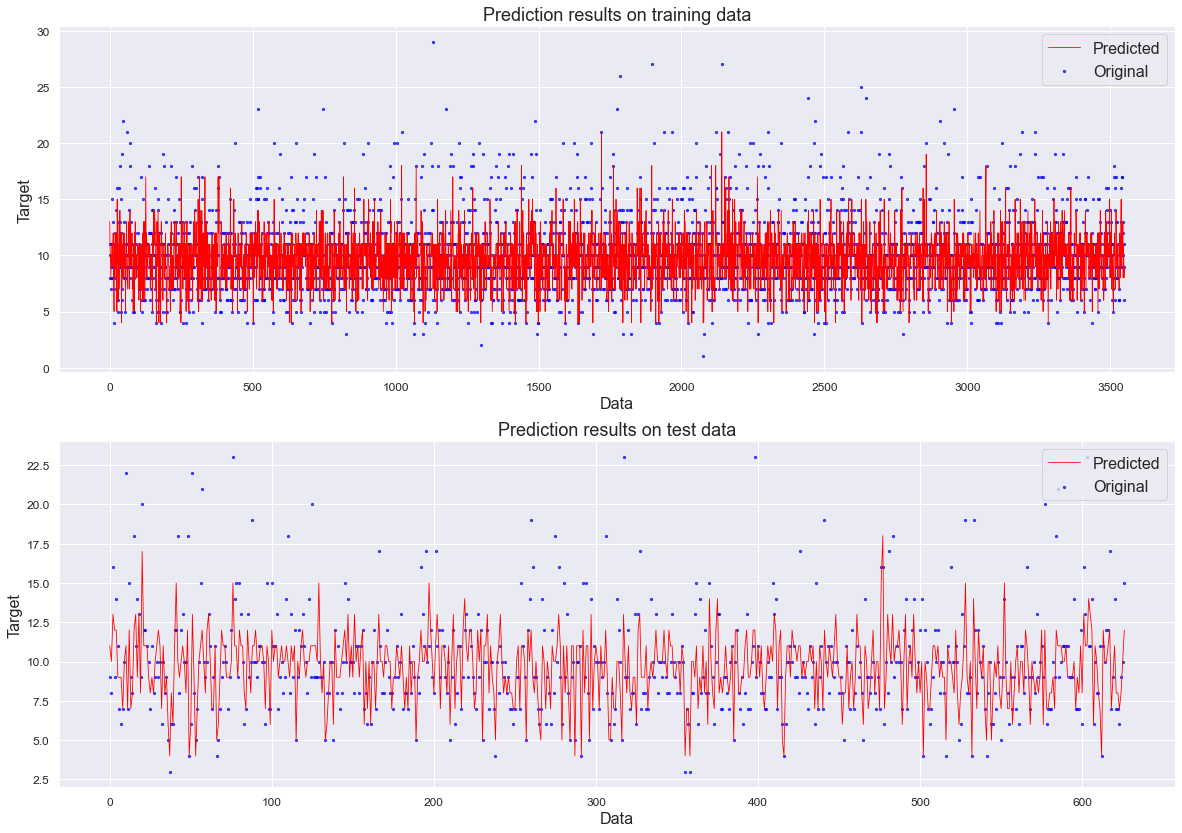

In [23]:
# Prediction results on training and test sets
fig, axes = plt.subplots(nrows=2, figsize=(20,14))
plt.sca(axes[0])
plot_predictions(y_train, train_pred)
plt.title('Prediction results on training data', fontsize=18)
plt.sca(axes[1])
plot_predictions(y_test, test_pred)
plt.title('Prediction results on test data', fontsize=18)
plt.show()

The above figure ilustrates the original data (blue dots) and their predictions (red line) on training (top) and test (buttom) sets. Please note that range of x-axis of both plots are different due to different number of observations in training and test sets, which makes the training set predictions plot looks more dense than the test set predictions'. It is noticed that overfitting might not be the case, since the prediction lines do not closely follow the original data point. Next, we can observe the distributions of the raw prediction erros.

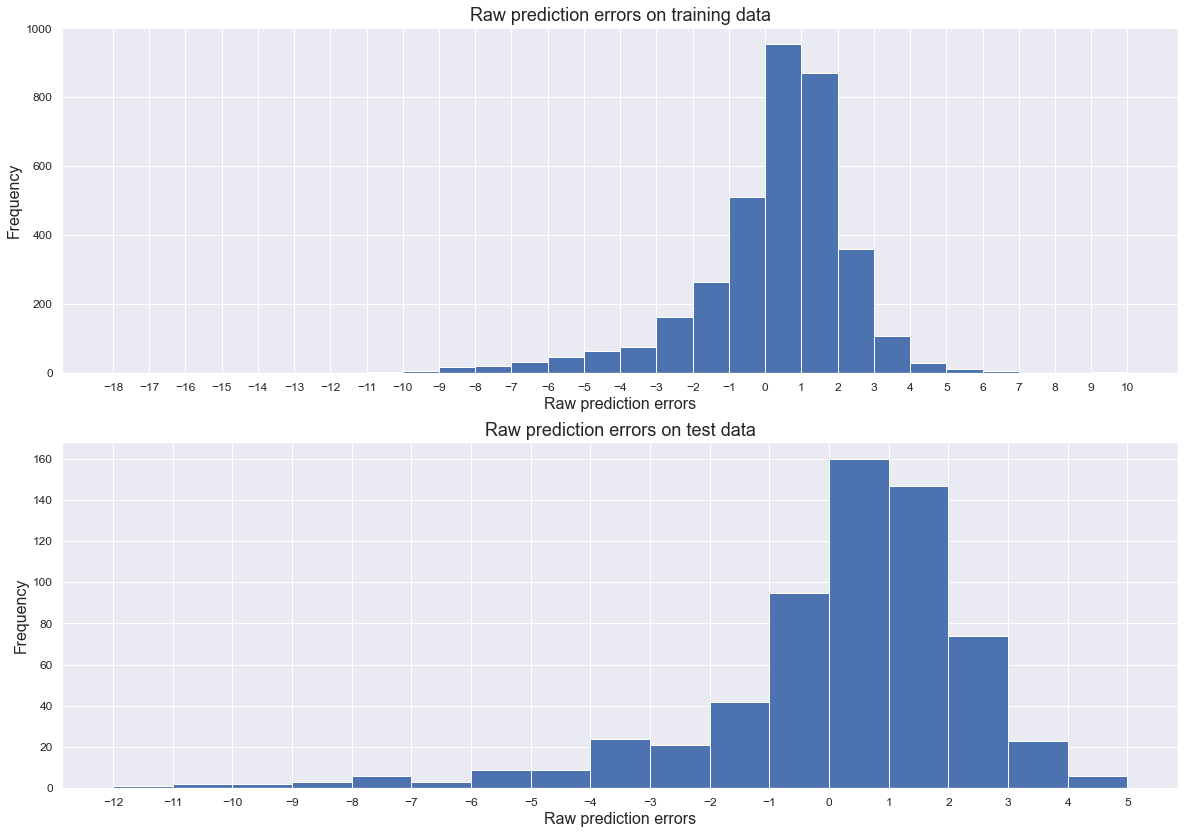

In [24]:
# Raw prediction errors on training and test sets
fig, axes = plt.subplots(nrows=2, figsize=(20,14))
plt.sca(axes[0])
plot_errors(y_train, train_pred)
plt.title('Raw prediction errors on training data', fontsize=18)
plt.sca(axes[1])
plot_errors(y_test, test_pred)
plt.title('Raw prediction errors on test data', fontsize=18)
plt.show()

The above plot illustrates histrogram showing the distribution of the raw prediction errors on the training (top) and the test (buttom) sets. Since the bins of the histograms were set based on the minimum and maximum errors of training and test set, the x-axis of both histogram are different. It is observed that most of the raw prediction errors are between -2 and +2 for both training and test set. Also, it is noticeable that the raw predictions errors are left-skewed, which suggests that the model tends to predict higher number of rings than the actual value (overestimate). In addition, the minimum and maximum errors of the training set are relatively large as compared to the test set, suggesting that there are outliers in the training data. 

#### 1.4 Comparison and summary <a class="anchor" id="1.4"></a>

The regressor tends to overestimate the number of rings for both training and test sets. Based on the mean absolute errors, training set MAEs are lower than test set MAEs for all the intermediate and final models, which is expected since the training set was fed to the model. However, the predictions on both training set and test set are off by around $\pm$2, suggesting the model predictive performances are not that much different.

Previously, we also made a comment on how the SVR is a good estimator by itself and not essentially a weak regressor. This makes the model much easier to fall into an overfitting trap, if the number of estimators were too high or the regularisation is not strong enough. Therefore, we have to be aware of the choice of weak regressor, its hyperparameters, and boosting's hyperparameter when using ensemble learning methods.

### 2. Project 2: Predicting red wine quality using Random Forests <a class="anchor" id="2"></a>

In this project, two Random Forest regressors will be built using the original data and the reduced-dimensional data to predict the red wine quality.

#### 2.1 Data loading and visualisation <a class="anchor" id="2.1"></a>

Firstly, the data was loaded using the function `read_csv()`. Since the file uses semi-colon separator, the argument `sep=';'` was passed to the read function. Then, the functions `head()`, `info()` and `describe()` were employed to initially inspect the structure of the data. Then, a pair plot together with the correlation matrix of all the features were illustrated. From here, we can notice the followings:

- Red wine dataset consists of **1599 observations** of **12 variables**, which are all numerical variables including the target (quality).
- There are no missing data. However, the values of features are quite different, suggesting data scaling might be required.
- From the pair plot, the distribution of all the variables seems to be skewed for some degrees except for density and pH. 
- Most of the features tend to have a moderately strong linear relationship, especially between citric acid and fixed acidity.
- Of all the features, **alcohol** are the most correlated to the target **quality** with the correlation of 0.4762, followed by **volatile acidity** and **sulphates**. with the correlation of -0.3906 and 0.2514, respectively.

Once we have done some data exploration, the data is splited into training (85%) and test (15%) sets. Then feature scaling was performed on both set using the `StandardScaler()`, `fit_transform()`, and `transform()` function.

The code snippets to performed the tasks and their outputs are shown as follows: 

In [25]:
# Data loading
wine = pd.read_csv('winequality-red.csv', sep=';')
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [26]:
# Checking the data structure
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [27]:
# Checking statistics
wine.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual sugar,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
free sulfur dioxide,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
total sulfur dioxide,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
pH,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


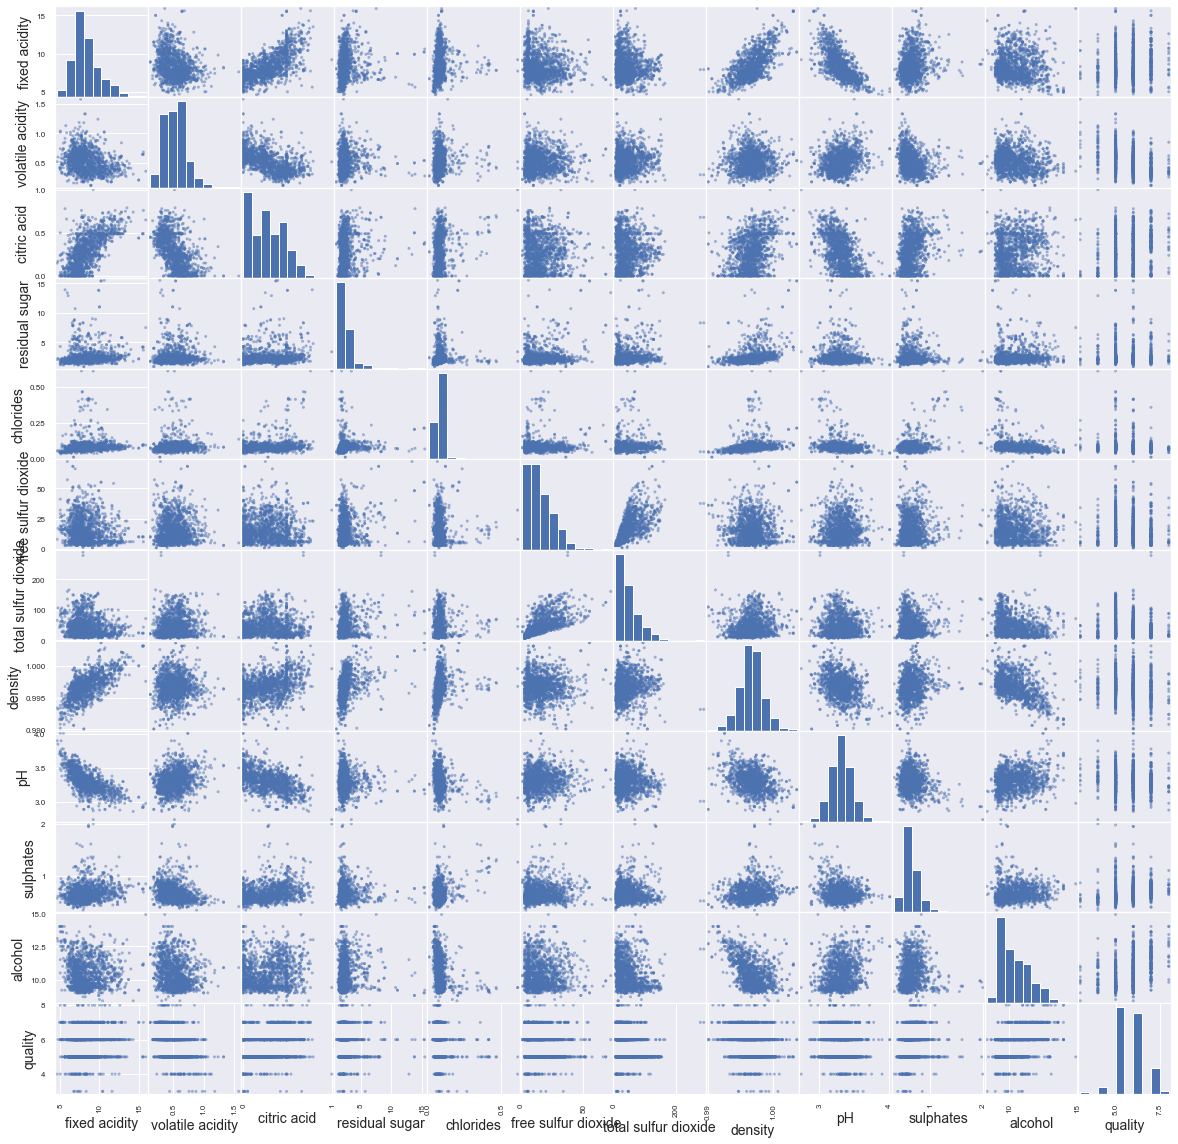

In [28]:
# Visualisation
scatter_matrix(wine, figsize=(20, 20));

In [29]:
# Pairwise correlation of features
wine.corr()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668,0.124052
volatile acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288,-0.390558
citric acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903,0.226373
residual sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075,0.013732
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141,-0.128907
free sulfur dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408,-0.050656
total sulfur dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654,-0.185100
density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180,-0.174919
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633,-0.057731
sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595,0.251397


In [30]:
# Extract target from features
X = wine.drop(['quality'], axis=1)
y = wine.quality

In [31]:
# Training and Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [32]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### 2.2 RF Regressor on full dimensional data <a class="anchor" id="2.2"></a>

Once the data was preprocessed, hyperparameters searching for Random Forest regressor was performed to optimise its predictive performance. Since grid searching usually take too long for many number of hyperparameters, `RandomizedSearchCV()` was instead employed in this section, and the mean absolute error scoring (`scoring='neg_mean_absolute_error'`) was used as the evaluation metric. It is noted that the hyperparameters for Random Forest are pretty much similar to what we see from Decision tree. The parameter grid consisting of five hyperparameters:

- `n_estimators` specifies the number of trees in the forest. The default number of trees is 100, so we try increasing the number of trees to 250 and 500. 
- `max_depth` specifies the maximum depth of the tree. The default is None, meaning that the nodes are expanded until all the leaves are pure. However, the unrestrained hyperparameter would result in the model being overfitted if the maximum depth being too high. Therefore, we can try building the model with maximum depth of 3, 5, 10, and 20.
- `max_features` determines the number of features to take into account when looking for the best split. The default parameter is set to 'auto', which means the maximum number of features is equal to the total number of features. Other two options are 'sqrt' and 'log2'. As the names suggest, they specifie the maximum number of features equal to square root of the total number of features and log base 2 of the total number of features, respectively.
- `min_samples_leaf` specifies the minimum number of samples required to be at a leaf node. This hyperparameter is crucial in confining the shape of the decision tree, so we do not want it to be too small or too large. Hence, randomisde searching is performed on three values: 1 (default), 2, and 3.
- `min_samples_split` specifies the minimum number of samples required to split an internal node. The default value is 2, so we can also try 3 and 4.

The `best_params_` from `RandomizedSearchCV` object suggests the best set of hyperparameters are n_estimators=250, max_depth=20, max_features='sqrt', min_samples_leaf=1, and min_samples_split=4.

Once we obtain the best set of hyperparameters, we can then obtain prediction results in integers and evaluate the model. The explanation of the results will be given at the end of this section.

The code snippets to perform the tasks are shown below:

In [ ]:
# Randomised searching for best combination of hyperparameters
#from sklearn.model_selection import RandomizedSearchCV
#from sklearn.ensemble import RandomForestRegressor

#param_grid = {'n_estimators': [100, 250, 500],
#              'max_depth': [3, 5, 10, 20],
#              'max_features' : ['auto', 'sqrt', 'log2'],
#              'min_samples_leaf': [1, 2, 3],
#              'min_samples_split': [2, 3, 4]
#             }

#forest_reg = RandomForestRegressor(criterion='mae', random_state=42)
#ran_search = RandomizedSearchCV(forest_reg, param_grid, cv=3, 
#                           scoring='neg_mean_absolute_error')
#ran_search.fit(X_train, y_train)
#ran_search.best_params_

In [33]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(bootstrap=True, n_estimators=250, 
                                   max_depth=20, min_samples_leaf=1,
                                   min_samples_split=4, max_features='sqrt',
                                   criterion='mae', random_state=42, n_jobs=-1)
forest_reg.fit(X_train, y_train)

RandomForestRegressor(criterion='mae', max_depth=20, max_features='sqrt',
                      min_samples_split=4, n_estimators=250, n_jobs=-1,
                      random_state=42)

In [34]:
# Prediction in integers
test_pred = np.round(forest_reg.predict(X_test))
train_pred = np.round(forest_reg.predict(X_train))

In [35]:
# test set MAE
np.round(mean_absolute_error(y_test, np.round(test_pred)),4)

0.4375

In [36]:
# training set MAE
np.round(mean_absolute_error(y_train, np.round(train_pred)),4)

0.2745

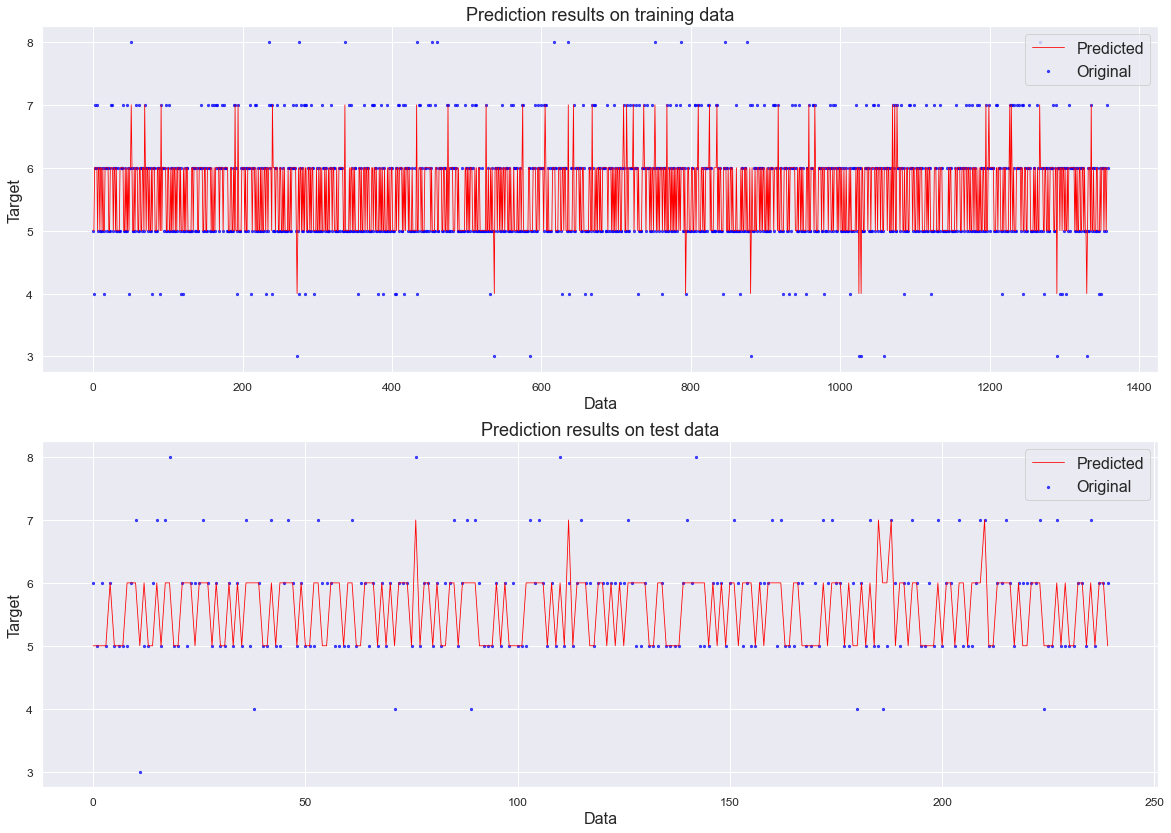

In [37]:
# Prediction results on training and test sets
fig, axes = plt.subplots(nrows=2, figsize=(20,14))
plt.sca(axes[0])
plot_predictions(y_train, train_pred)
plt.title('Prediction results on training data', fontsize=18)
plt.sca(axes[1])
plot_predictions(y_test, test_pred)
plt.title('Prediction results on test data', fontsize=18)
plt.show()

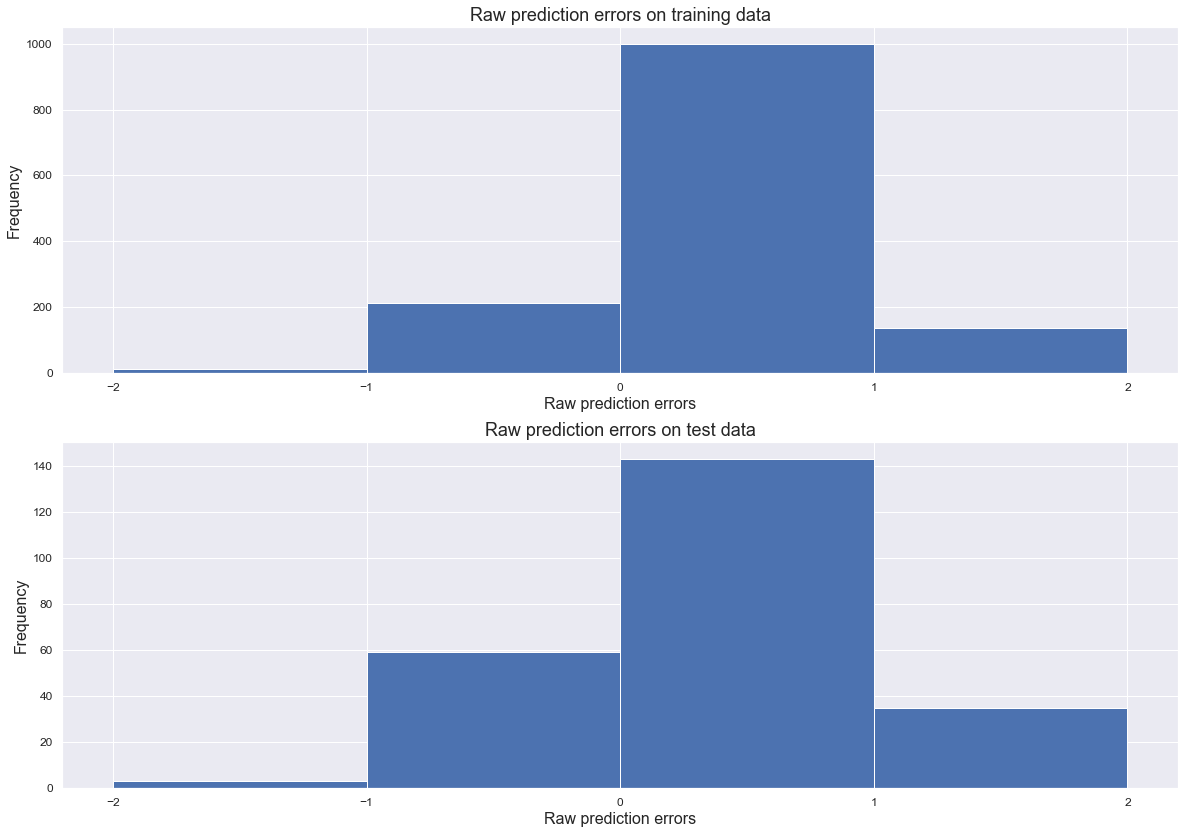

In [38]:
# Raw prediction errors on training and test sets
fig, axes = plt.subplots(nrows=2, figsize=(20,14))
plt.sca(axes[0])
plot_errors(y_train, train_pred)
plt.title('Raw prediction errors on training data', fontsize=18)
plt.sca(axes[1])
plot_errors(y_test, test_pred)
plt.title('Raw prediction errors on test data', fontsize=18)
plt.show()

From the above outputs and visualisations, we can notice the followings:

- The training set MAE (0.2745) is lower than test set MAE (0.4375), which is expected. However, the MAEs are still quite high, which suggests the model might be underfitted.
- The plots of the prediction results affirm the investigation that the model is probably underfitted, as the prediction lines only vary between 4 and 7 for the training data and between 5 and 7 for the test set.
- The distribution of raw prediction errors on the training and test data appear to be quite similar.

#### 2.3 Feature importance & dimensionality reduction <a class="anchor" id="2.3"></a>

In this section, we made use of the `SelectFromModel()` function with threshold=0.05 to perform feature selection on the red wine data. Firstly, we inpect the `feature_importances_` object of the Random Forest model in the previus section. With importance treshold of 5%, five features- namely, citric acid, pH, fixed acidity, residual sugar, and free sulfur dioxide should be dropped. Then, the function `SelectFromModel()` was employed to automatically select the features with 5% threshold. To perform feature selection, the `get_support` method from the `SelectFromModel` object was used as the selection index on the features of training and test sets. 

The code to perform the task are shown as follows:

In [39]:
# Inspect feature importance
feature_importance = pd.Series(forest_reg.feature_importances_,
                              index=X.columns).sort_values(ascending=False)
feature_importance

alcohol                 0.245615
sulphates               0.152155
volatile acidity        0.139026
total sulfur dioxide    0.097939
density                 0.082596
chlorides               0.054640
citric acid             0.049693
pH                      0.047755
fixed acidity           0.046248
residual sugar          0.044958
free sulfur dioxide     0.039374
dtype: float64

In [40]:
# Feature selection with threshold=0.05
from sklearn.feature_selection import SelectFromModel
sel = SelectFromModel(RandomForestRegressor(bootstrap=True, n_estimators=250, 
                                   max_depth=20, min_samples_leaf=1,
                                   min_samples_split=4, max_features='sqrt',
                                   criterion='mae', random_state=42, n_jobs=-1),
                     threshold=0.05)
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestRegressor(criterion='mae', max_depth=20,
                                                max_features='sqrt',
                                                min_samples_split=4,
                                                n_estimators=250, n_jobs=-1,
                                                random_state=42),
                threshold=0.05)

In [41]:
# New training and test data with selected features
X_train2=X_train[:,(sel.get_support())]
X_test2=X_test[:,(sel.get_support())]

#### 2.4 RF Regressor on reduced-dimensional data <a class="anchor" id="2.4"></a>

In this section, the Random Forest regressor was built based on the reduced-dimensional data obtained in the previous section. Randomised searching was performed using the same parameter grid. The best set of hyperparameters obtained is the same as what we obtained in section 2.2, except for the `min_samples_split` parameter is set to 2 instead of 4.

Then, the new Reandom Forest regressor was trained, and the prediction results on training and test sets are obtained and converted to integer using the `round()` function. The plots of the prediction results and histograms of the raw prediction errors on the training and test sets are also reported. The explanation of these outputs and visualisations are given at the end of this section.

In [ ]:
# Randomised searching for best combination of hyperparameters
#from sklearn.model_selection import RandomizedSearchCV
#from sklearn.ensemble import RandomForestRegressor

#param_grid = {'n_estimators': [100, 250, 500],
#              'max_depth': [3, 5, 10, 20],
#              'max_features' : ['auto', 'sqrt', 'log2'],
#              'min_samples_leaf': [1, 2, 3],
#              'min_samples_split': [2, 3, 4]
#             }

#forest_reg = RandomForestRegressor(criterion='mae', random_state=42)
#ran_search = RandomizedSearchCV(forest_reg, param_grid, cv=3, 
#                           scoring='neg_mean_absolute_error')
#ran_search.fit(X_train2, y_train)
#ran_search.best_params_

In [42]:
forest_reg2 = RandomForestRegressor(bootstrap=True, n_estimators=250, 
                                   max_depth=20, min_samples_leaf=1,
                                   min_samples_split=2, max_features='sqrt',
                                   criterion='mae', random_state=42, n_jobs=-1)
forest_reg2.fit(X_train2, y_train)

RandomForestRegressor(criterion='mae', max_depth=20, max_features='sqrt',
                      n_estimators=250, n_jobs=-1, random_state=42)

In [43]:
# Prediction in integers
test_pred2 = np.round(forest_reg2.predict(X_test2))
train_pred2 = np.round(forest_reg2.predict(X_train2))

In [44]:
# test set MAE
np.round(mean_absolute_error(y_test, np.round(test_pred2)),4)

0.4208

In [45]:
# training set MAE
np.round(mean_absolute_error(y_train, np.round(train_pred2)),4)

0.2539

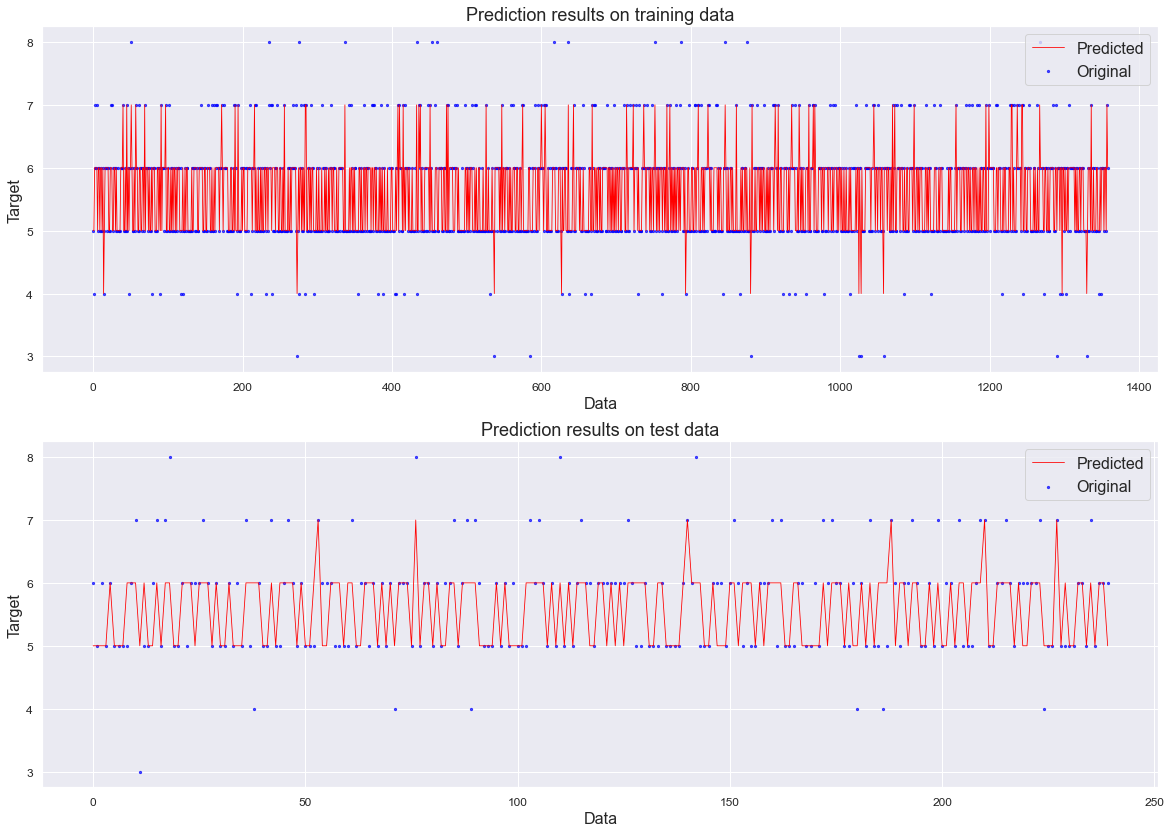

In [46]:
# Prediction results on training and test sets
fig, axes = plt.subplots(nrows=2, figsize=(20,14))
plt.sca(axes[0])
plot_predictions(y_train, train_pred2)
plt.title('Prediction results on training data', fontsize=18)
plt.sca(axes[1])
plot_predictions(y_test, test_pred2)
plt.title('Prediction results on test data', fontsize=18)
plt.show()

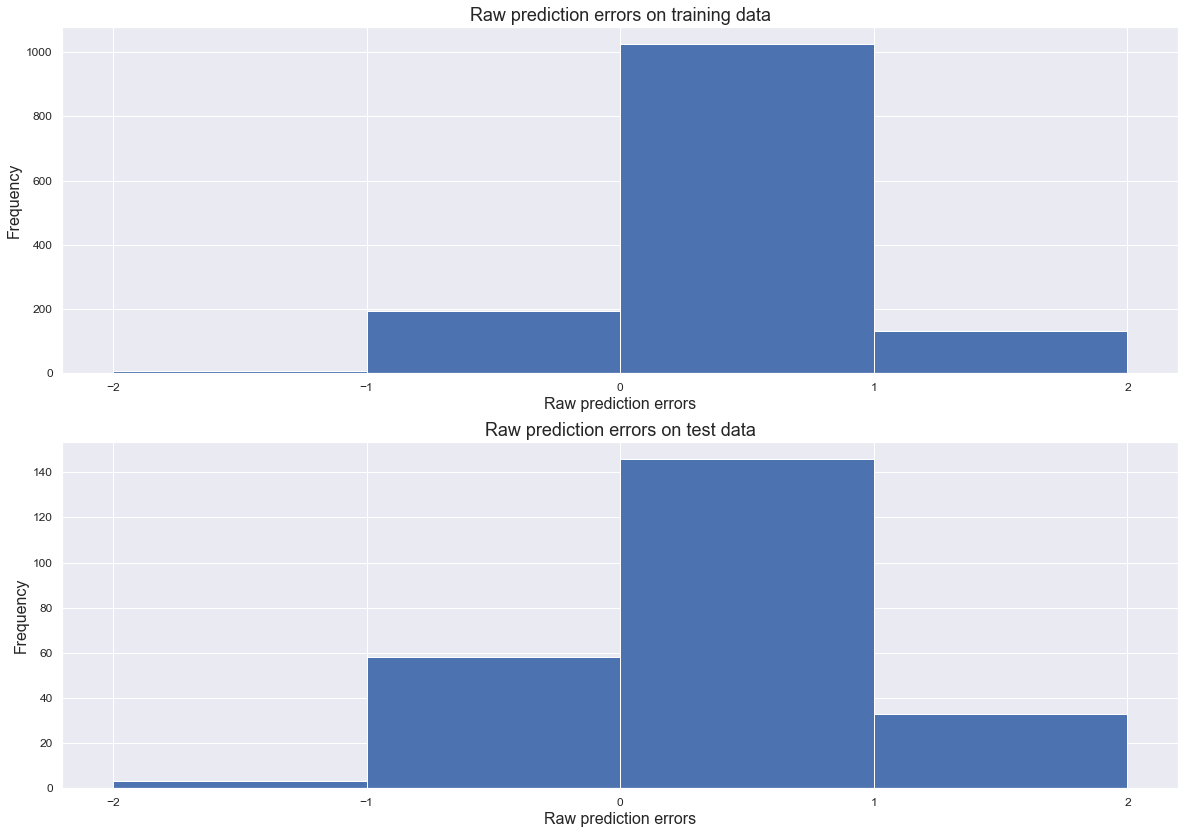

In [47]:
# Raw prediction errors on training and test sets
fig, axes = plt.subplots(nrows=2, figsize=(20,14))
plt.sca(axes[0])
plot_errors(y_train, train_pred2)
plt.title('Raw prediction errors on training data', fontsize=18)
plt.sca(axes[1])
plot_errors(y_test, test_pred2)
plt.title('Raw prediction errors on test data', fontsize=18)
plt.show()

From the above outputs and visualisations, we can notice the followings:

- The training set MAE (0.2539) is lower than test set MAE (0.4208) by about 0.17, suggesting the RF model is not overfitted.
- The plots of the prediction results looks pretty similar to the previous RF model with the prediction lines vary between 4 and 7 for the training data and between 5 and 7 for the test set.
- The distribution of raw prediction errors on the training and test data look almost similar in shape with $\approx$74% of the training data and $\approx$60% of the test data were correctly predicted (raw prediction error equals to zero).
- The histograms of raw prediction errors show that $\approx$25% of the test data and $\approx$15% of the training data were underestimated by the regressor.
- Oppositely, $\approx$7% of the training data and $\approx$15% of the test data were overestimated by the regressor.

#### 2.5 Comparison and conclusion <a class="anchor" id="2.5"></a>

It is noticed that the prediction results of the both RF regressors only vary between 4 and 7, which might due to most of the original target values ($\gt$95%) vary between 4 and 7. Also, the distribution of raw prediction errors for both RF models are pretty similar. Although the visualisations look pretty much the same, the training and test sets' MAE of the RF regressor based on the reduced dimensional data slightly improves from the full-dimensional data RF regressor's. This suggests that feature selection helps improves the accuracy of the model by excluding redundant attributes such as acid-based features (citric acid and fixed acidity) and free sulfur dioxide. It is noted that including redundant attributes usually be misleading to the modeling algorithms, especially decision tree and random forest algorithms, and will result in an overfitting model. Therefore, performing feature selection is essential and will benefits the prediction performance of the model by reducing overfitting and improving prediction accuracy. In addition, feature selection will immensely benefit high dimensional sparse data by reducing the training time.

### References <a class="anchor" id="Ref"></a>

Geron, A. (2019). *Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems (2nd ed.)* O’Reilly. Sebastopol, CA.

Pedregosa et al. “Scikit-learn: Machine Learning in Python Documentation.” https://scikit-learn.org/stable/index.html.